# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import datetime
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from progressbar import ProgressBar
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Exploration & Preprocessing
In this section we will explore the data loaded (porfolio, profile & transcript). In addition, the df's are going to be preprocessed and this is the part were we will transform our data to be loaded into the db and later be fed into ML pipelines.

### 1a. Portofolio

In [2]:
print(portfolio.shape)
portfolio.head(10)

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [4]:
# check for any nulls existing in this df.
# we should expect zeros since the subset contains only 10 rows which is printed in the cell above and contains no nulls.
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

On first thoughts we could turn each channel type into a column with 0's and 1's.
Also we could convert the encoded id's into integers.

In [5]:
# checking the types of all columns.
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [6]:
# check the number of unique offers.
portfolio.id.nunique()

10

lets also convert offer_type column into categorical variables.

In [7]:
# what are the available offer_types
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
def id_mapper(df):
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

def preprocess(df):
    '''
    This function should have common preprocessing on dataframe to be used by other preprocessing functions. 
    - Only takes copy of df
    
    INPUT:
    df - (pandas df).
    
    OUTPUT:
    copy_df -  (pandas df) a copy of the original dataframe.
    '''
    # use int ids instead of hashes.
#     id_encoded = id_mapper(df)
#     del df['id']
#     df['id'] = id_encoded
#     df.set_index('id', inplace=True)
    
    return df.copy()
    
def preprocess_portfolio(portfolio):
    '''
    This function cleans the portfolio datafram. 
    - Get dummies for offer_type and channels.
    
    INPUT:
    portfolio - (pandas df) this is a portfolio df.
    
    OUTPUT:
    df -  (pandas df) dataframe having the profile df cleaned.
    '''
    df = preprocess(portfolio)
    
    # normalize portfolio duration to match that of transcript time.
    df['duration'] = df['duration'] * 24
    
    # get dummies for offer type and channels
    offer_type = pd.get_dummies(df['offer_type'])
    
    # https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
    channels = pd.get_dummies(df['channels'].apply(pd.Series).stack()).sum(level=0)
    
    # drop the old columns and add the new dummy columns
    df.drop(columns=['channels', 'offer_type'], inplace=True)
    df = pd.concat([channels, df, offer_type], axis=1)
    
    return df
    
processed_portfolio = preprocess_portfolio(portfolio)

In [9]:
processed_portfolio.head()

,email,mobile,social,web,reward,difficulty,duration,id,bogo,discount,informational
0,1,1,1,0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,1,1,1,1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,1,1,0,1,0,0,96,3f207df678b143eea3cee63160fa8bed,0,0,1
3,1,1,0,1,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,1,0,0,1,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


### 1b. profile

In [10]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
profile.id.nunique()

17000

In [13]:
profile.duplicated().sum()

0

In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


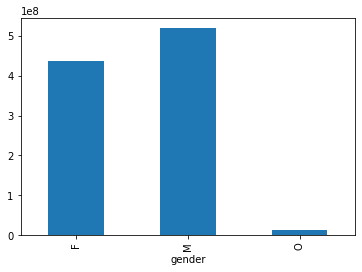

In [15]:
# total income earned grouped by gender
# this doesn't tell much since the count of gender are not equal. We should try to normalize it.
profile.groupby(['gender']).sum()['income'].plot(kind='bar');

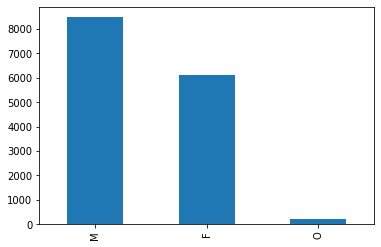

In [16]:
# there are more males then other genders.
profile['gender'].value_counts().plot(kind='bar');

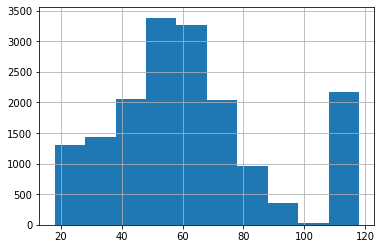

In [17]:
profile['age'].hist();

#### What is mean age across different genders?
It seems across different genders it's around the 50's

In [18]:
# it seems the median is the same 
profile[['gender', 'age']].groupby(['gender']).mean()

,age
gender,
F,57.544950
M,52.116690
O,54.400943


#### It seems that genders have similar distribution

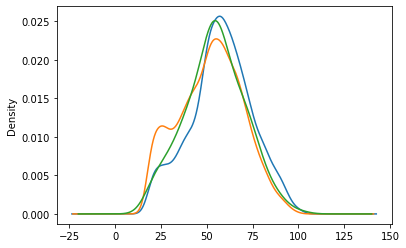

In [19]:
profile[['gender', 'age']].groupby(['gender']).age.plot(kind='kde');

#### How is the income across age?
there seems to be pattern that income increases with age, however there are some exceptions.

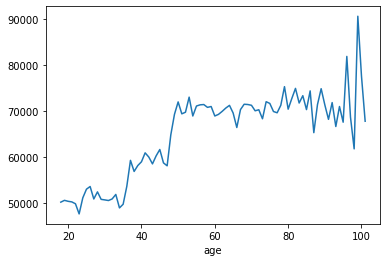

In [20]:
profile.groupby(['age'])['income'].mean().plot(kind='line');

In [21]:
# it seems that the age 118 has the highest count.
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [22]:
# This age seems to be untrusted because it's contributing to a lot of empty values.
# todo is there a way of filling in these data accurately without dropping the null rows? 
profile.query('age == 118')

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [23]:
# It seems all of the missing values are coming from this age.
print(profile.query('age == 118').isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [24]:
noise_data_idx = profile.query('age == 118').index
profile.drop(index=noise_data_idx).isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

#### Plot the distribution of income range
With qcut we ask pandas to specify the bins in order to have an evenly distribution.

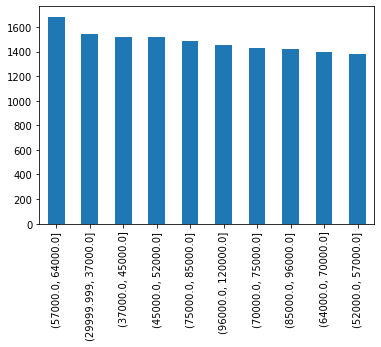

In [25]:
# spreading the income over ranges, to check how offers are affected by income.
# only for visualization and that's why we are dropping the null.
dropped_nulls = profile.drop(index=noise_data_idx)
income_range = pd.qcut(dropped_nulls['income'], q=10)
income_range.value_counts().plot(kind='bar');

In [26]:
def preprocess_profile(profile):
    '''
    This function cleans the profile datafram. 
    - It remove the noise data
    - Get dummies for gender
    - Parses became_member_on and splits onto several columns
    - Generates a new column called member_duration that represents for how long this user has been a member in days.
    
    INPUT:
    profile - (pandas df) this is a profile df.
    
    OUTPUT:
    df -  (pandas df) dataframe having the profile df cleaned.
    '''
    
    df = preprocess(profile)
    
    # lets drop the noise entries such as 118 ages.
    # todo is there a way of filling in these data accurately without dropping the null rows? 
    noise_data_idx = df.query('age == 118').index
    df.drop(index=noise_data_idx, inplace=True)
    
    # split gender into dummies. Since no missing values exist after removing 118, this should be safe.
    gender = pd.get_dummies(df['gender'], prefix='gender', prefix_sep='_')
    
    # Parse the date.
    dt = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    df['became_member_year'] = dt.dt.year
    df['became_member_month'] = dt.dt.month
    df['became_member_day'] = dt.dt.day
    
    # lets keep track of how long this user has been a member.
    df['member_duration'] = (datetime.datetime.today().date() - dt.dt.date).dt.days

    df.drop(columns=['gender', 'became_member_on'], inplace=True)
    
    # add the dummies to our profile.
    df = pd.concat([df, gender], axis=1)
    
    return df

In [27]:
processed_profile = preprocess_profile(profile)

In [28]:
processed_profile.head()

,age,id,income,became_member_year,became_member_month,became_member_day,member_duration,gender_F,gender_M,gender_O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1223,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1290,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,938,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1014,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,1104,0,1,0


#### What does the age distribution look like after removing the nulls?

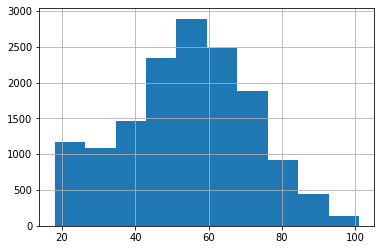

In [29]:
# lets see the distribution after age 118 was removed.
processed_profile['age'].hist();

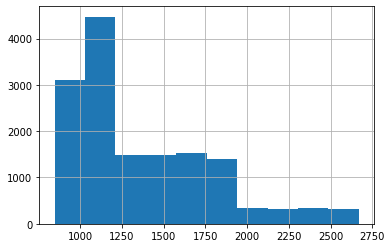

In [30]:
processed_profile['member_duration'].hist();

### 1c Transcript analysis

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [31]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [32]:
transcript.shape

(306534, 4)

#### What are the types of events?

In [33]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

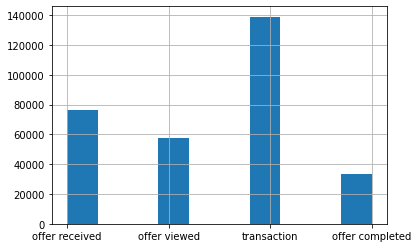

In [34]:
transcript.event.hist();

#### What doest transcation events look like?

In [35]:
transcript.query("event == 'transaction'").head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


#### Are there null values?

In [36]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

#### Earlier with profiles we removed users with age 118, do they have records in transcript?

In [37]:
profile_118 = profile.query('age == 118')
t_118 = transcript['person'].isin(profile_118['id'].tolist()).sum()
print('Number of transcripts for age 118: {}'.format(t_118))

Number of transcripts for age 118: 33772


In [38]:
print('They are contributing to {}%'.format(100*t_118/transcript.shape[0]))

They are contributing to 11.017374907840566%


#### Remove the users with age 118 from transcripts since we don't have record of them in our profile.

In [39]:
def preprocess_transcript(transcript):
    '''
    INPUT:
    transcript - (pandas df) this is a transcript df.
    
    OUTPUT:
    df -  (pandas df) dataframe having the transcript df cleaned.
    '''
    df = preprocess(transcript)
    
    df = df[~df['person'].isin(profile_118['id'].tolist())]
    events = pd.get_dummies(df.event)
    
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
    df['amount'] = df['value'].apply(lambda x: x.get('amount'))
    df.drop(columns=['value'], inplace=True)
    
    df = pd.concat([df, events], axis=1)
    
    return df

In [40]:
processed_transcript = preprocess_transcript(transcript)

In [41]:
processed_transcript.head()

,person,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0


In [42]:
# making sure person 118 was removed
processed_transcript['person'].isin(profile_118['id'].tolist()).sum()

0

#### Lets examin a random user

In [43]:
processed_portfolio[processed_portfolio['id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9']

,email,mobile,social,web,reward,difficulty,duration,id,bogo,discount,informational
3,1,1,0,1,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0


In [44]:
processed_transcript[processed_transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef'].head()

,person,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,None,19.89,0,0,0,1
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,None,17.78,0,0,0,1


#### Separate offers into new dataframe

In [45]:
def split_transcript_df(transcript):
    '''
    This function splits transcript df into two dfs, one are the offers and the other is the transactions.
    
    INPUT:
    transcript - (pandas df) this is a transcript df.
    
    OUTPUT:
    offer_df -  (pandas df) dataframe having the transcation rows filtered out.
    transaction_df - (pandas df) dataframe having the transcation rows filtered out.
    '''
    split_df = transcript.copy()
    
    # extract offers.
    offer_df = split_df[split_df['transaction'] != 1]
    offer_df = offer_df.drop(columns=['transaction', 'amount'])
    
    transaction_df = split_df[split_df['transaction'] == 1]
    transaction_df = transaction_df.drop(columns=['offer_id', 'offer completed', 'offer received', 'offer viewed'])
    
    return offer_df, transaction_df

In [46]:
def combine_data(transcript, portfolio, profile):
    """
    This function merges transcript, portfolio and profile into one df. It also adds some usefule infomration such as
    the user interaction towards a certain offer (called user_impression).
    
    INPUT:
    transcript - (pandas df) this is a preprocessed_transcript df.
    portfolio - (pandas df) this is a preprocessed_portfolio df.
    profile - (pandas df) this is a preprocessed_profile df.
    
    OUTPUT:
    combined_data - (pandas df)
    """
    offer_df, transaction_df = split_transcript_df(transcript)

    combined_data = []
    val_users = offer_df['person'].unique().tolist()

    # init progress bar because this will take too long.
    pbar = ProgressBar()
    
    for user in pbar(val_users):
        user_offers = offer_df[offer_df['person'] == user]

        user_transactions = transaction_df[transaction_df['person'] == user]
        user_received_offers = user_offers[user_offers['offer received'] == 1]
        user_viewed_offers = user_offers[user_offers['offer viewed'] == 1]
        user_completed_offers = user_offers[user_offers['offer completed'] == 1]

        rows = []
        for _, offer in user_received_offers.iterrows():

            offer_details = portfolio.query("id == @offer.offer_id")
            offer_received_time = offer.time

            # calculate deadline for offer.
            duration = offer_details['duration'].tolist()[0]
            offer_deadline = offer_received_time + duration

            # find the transactions during the offer.
            viewed_during_offer = np.logical_and(user_viewed_offers['time'] >= offer_received_time,
                                                 user_viewed_offers['time'] <= offer_deadline)

            user_transaction_during_offer = user_transactions[
                np.logical_and(user_transactions['time'] >= offer_received_time,
                               user_transactions['time'] <= offer_deadline)]

            # incase it is an informational offer
            offers_completed = viewed_during_offer
            user_impression = np.logical_and(offers_completed.sum() > 0,
                                             user_transaction_during_offer['amount'].sum() > 0)

            # incase it is not an informational offer
            if offer_details.informational.values[0] == 0:
                offers_completed = np.logical_and(user_completed_offers['time'] >= offer_received_time,
                                                  user_completed_offers['time'] <= offer_deadline)

                user_impression = np.logical_and(viewed_during_offer.sum() > 0, offers_completed.sum() > 0) and \
                                  (user_transaction_during_offer['amount'].sum() >=
                                   offer_details['difficulty'].tolist()[0])

            summary = {'person': user,
                       'offer_id': offer.offer_id,
                       'user_impression': int(user_impression),
                       'total_amount': user_transaction_during_offer['amount'].sum()}

            if user_impression:
                summary['user_impression'] = 1.0

            combined_data.append(summary)

    combined_data = pd.DataFrame(combined_data)
    combined_data = combined_data.merge(profile, left_on='person', right_on='id', how='left')
    combined_data.drop(columns='id', inplace=True)
    combined_data = combined_data.merge(portfolio, left_on='offer_id', right_on='id', how='left')
    combined_data.drop(columns='id', inplace=True)

    return combined_data

In [47]:
def get_combined_data(transcript, portfolio, profile, filename='combined_data.pkl'):
    '''
    This function loads the df from storage. If it does not exist, it calls combine_data function
    and saves the result on disk afterwards.
    
    INPUT:
    transcript - (pandas df)
    portfolio - (pandas df)
    profile - (pandas df)
    filename - (string) location of pickle file to be saved.
    
    OUTPUT:
    user_by_offer -  (pandas df) dataframe having user vs offer matrix.
    '''
    # load user_by_offer if exists.
    try:
        combined_data = pd.read_pickle(filename)
    except FileNotFoundError:
        print ('File not found. Generating df')
        combined_data = combine_data(transcript, portfolio, profile)

        # save data to disk
        pd.to_pickle(combined_data, filename)
    
    return combined_data

In [48]:
combined_data = get_combined_data(processed_transcript, processed_portfolio, processed_profile)

In [49]:
combined_data.head(10)

,person,offer_id,user_impression,total_amount,age,income,became_member_year,became_member_month,became_member_day,member_duration,...,email,mobile,social,web,reward,difficulty,duration,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,37.67,75,100000.0,2017,5,9,1290,...,1,1,0,1,5,5,168,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1.0,49.39,75,100000.0,2017,5,9,1290,...,1,1,1,0,0,0,72,0,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1.0,48.28,75,100000.0,2017,5,9,1290,...,1,1,1,0,10,10,168,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1.0,48.28,75,100000.0,2017,5,9,1290,...,1,1,1,1,5,5,120,1,0,0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,0.00,68,70000.0,2018,4,26,938,...,1,1,0,1,2,10,168,0,1,0
5,e2127556f4f64592b11af22de27a7932,3f207df678b143eea3cee63160fa8bed,0.0,0.00,68,70000.0,2018,4,26,938,...,1,1,0,1,0,0,96,0,0,1
6,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,18.42,68,70000.0,2018,4,26,938,...,1,1,0,1,5,5,168,1,0,0
7,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,1.0,18.42,68,70000.0,2018,4,26,938,...,1,1,1,1,2,10,240,0,1,0
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,9.54,65,53000.0,2018,2,9,1014,...,1,1,1,1,5,5,120,1,0,0
9,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.00,65,53000.0,2018,2,9,1014,...,1,1,0,1,5,5,168,1,0,0


### 2. SVD as a recommendation engine.
The main idea here is to be able to predict or recommend the kind of offer that a user will act on. Meaning that they will follow the whole cycle, which is offer received, then offer viewed and lastly offer completed. This marks a successful offer.<br/>
<br/>
First we need to create user_item_matrix, this will match users/person against offers. And the possible entries would be:
* Nan -> indicates that this user had not received that offer
* 0 -> indicates that this user received that offer but didn't act on it.
* \> 0 -> shows that the user received offer, viewed it and completed it.

In [50]:
def create_user_item_matrix(combined_data):
    """
    This function creates user_by_offer matrix.

    INPUT:
    combined_data - (pandas df) dataframe that contains combined data of portfolio, profile and offers.

    OUTPUT:
    user_by_offer -  (pandas df) dataframe having user vs offer matrix.
    """

    # create an empty matrix.
    user_by_offer = combined_data.groupby(['person', 'offer_id'])['total_amount'].agg(lambda x: np.nan).unstack()

    # init progress bar because this will take too long.
    pbar = ProgressBar()

    for _, user_interaction in pbar(combined_data.iterrows()):
        
        # we decide to give low weights to informational offers. This is a biased decision.
        weight = 0.1 if user_interaction.informational == 1 else 1.0
        
        person = user_interaction.person
        offer = user_interaction.offer_id
        if np.isnan(user_by_offer.loc[person, offer]):
            user_by_offer.loc[person, offer] = 0.0

        user_by_offer.loc[person, offer] += weight*user_interaction.user_impression

    return user_by_offer

#### Most of the entries have NaN, as such we could use FunkSVD to fill in the missing entries

In [51]:
user_by_offer = create_user_item_matrix(combined_data)
user_by_offer.head()

| |                #                              | 66500 Elapsed Time: 0:00:58


offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,0.1,NaN,0.1,NaN,NaN,1.0,1.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,2.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.1,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,0.1,NaN,0.1,NaN,NaN,NaN,2.0


In [52]:
user_by_offer.shape

(14820, 10)

In [53]:
def create_train_test(df, training_ratio=0.8):
    '''    
    INPUT:
    df - (pandas df) dataframe to split into train and test
    training_size - (float) ratio of training set size.
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    training_size = (int) (df.shape[0] * training_ratio)
    
    training_df = df.head(training_size)
    validation_df = df.iloc[training_size:]
    
    return training_df, validation_df

In [54]:
train_df, test_df = create_train_test(combined_data, 0.7)
train_df.shape, test_df.shape

((46550, 23), (19951, 23))

In [55]:
user_by_offer_train = create_user_item_matrix(train_df)
user_by_offer_train.head()

| |                                    #          | 46549 Elapsed Time: 0:01:00


offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,2.0
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,0.1,NaN,0.1,NaN,NaN,NaN,2.0
00426fe3ffde4c6b9cb9ad6d077a13ea,0.0,NaN,0.0,NaN,NaN,0.1,NaN,NaN,NaN,1.0
005500a7188546ff8a767329a2f7c76a,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN


In [56]:
user_by_offer_test = create_user_item_matrix(test_df)
user_by_offer_test.head()

| |                                    #          | 19950 Elapsed Time: 0:00:15


offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,0.1,NaN,0.1,NaN,NaN,1.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.1,1.0,NaN,1.0,NaN
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0
00ae03011f9f49b8a4b3e6d416678b0b,NaN,2.0,0.0,NaN,NaN,0.0,NaN,2.0,NaN,NaN


In [57]:
def FunkSVD(user_offer_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    offer_mat:
    user_offer_mat - (numpy array) a matrix with users as rows, offers as columns, and success as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = user_offer_mat.shape[0]
    n_offers = user_offer_mat.shape[1]
    num_completion = np.count_nonzero(~np.isnan(user_offer_mat))
    
    # initialize the user and offer matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the viewed or completed exists
                if user_offer_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = user_offer_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_completion))
        
    return user_mat, offer_mat 

In [58]:
# Create user-by-item matrix
train_data_np = np.array(user_by_offer_train)

# Fit FunkSVD with the specified hyper parameters to the training data
user_train_mat, offer_train_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.391600
2 		 0.337636
3 		 0.336009
4 		 0.334380
5 		 0.332738
6 		 0.331081
7 		 0.329408
8 		 0.327714
9 		 0.325996
10 		 0.324252
11 		 0.322476
12 		 0.320663
13 		 0.318809
14 		 0.316908
15 		 0.314953
16 		 0.312937
17 		 0.310852
18 		 0.308690
19 		 0.306442
20 		 0.304098
21 		 0.301647
22 		 0.299080
23 		 0.296385
24 		 0.293549
25 		 0.290563
26 		 0.287414
27 		 0.284093
28 		 0.280590
29 		 0.276896
30 		 0.273006
31 		 0.268915
32 		 0.264622
33 		 0.260129
34 		 0.255442
35 		 0.250570
36 		 0.245525
37 		 0.240325
38 		 0.234991
39 		 0.229544
40 		 0.224012
41 		 0.218422
42 		 0.212802
43 		 0.207181
44 		 0.201588
45 		 0.196047
46 		 0.190584
47 		 0.185218
48 		 0.179969
49 		 0.174850
50 		 0.169871
51 		 0.165040
52 		 0.160361
53 		 0.155835
54 		 0.151460
55 		 0.147233
56 		 0.143148
57 		 0.139199
58 		 0.135377
59 		 0.131675
60 		 0.128083
61 		 0.124595
62 		 0.121201
63 		 0.117893
64 		 0

In [59]:
user_train_mat.shape, offer_train_mat.shape

((9829, 15), (15, 10))

In [60]:
user_train_mat[10:]

array([[ 0.27594744,  0.16310398,  0.8324089 , ...,  0.10386147,
         0.09814305,  0.56348367],
       [ 0.1847592 ,  0.62888621,  0.82973341, ...,  0.48429277,
         0.61878378,  0.69082644],
       [ 0.30901839,  0.37739952,  0.77052484, ...,  0.78745739,
         0.880516  ,  0.49461639],
       ...,
       [-0.17478764,  0.81879522,  0.95499529, ...,  0.40455666,
         0.79496362,  0.03363471],
       [ 0.64958287,  1.174336  ,  0.87159964, ...,  0.48151415,
         0.47062152,  0.41282384],
       [ 0.36632963,  1.21717018,  0.50431247, ...,  0.52220611,
         0.18668948,  0.76905797]])

In [61]:
def predict_impression(user_matrix, offer_matrix, user_id, offer_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offer df
    
    OUTPUT:
    pred - the predicted impression for user_id-offer_id according to FunkSVD
    '''
    # Use the training data to create a series of users and movies that matches the ordering in training data
    user_ids_series = np.array(user_by_offer_train.index)
    offer_ids_series = np.array(user_by_offer_train.columns)
    
    # User row and Movie Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    offer_col = np.where(offer_ids_series == offer_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
    
    return pred

In [62]:
# Test your function with user-offer in the user-offer matrix (notice this is a nan)
pred_val = predict_impression(user_train_mat, offer_train_mat, \
                          '0020c2b971eb4e9188eac86d93036a77', '0b1e1539f2cc45b7b9fa7c272da2e1d7')
pred_val

0.42858175933885057

In [63]:
user_by_offer_test.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,0.1,NaN,0.1,NaN,NaN,1.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.1,1.0,NaN,1.0,NaN
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0
00ae03011f9f49b8a4b3e6d416678b0b,NaN,2.0,0.0,NaN,NaN,0.0,NaN,2.0,NaN,NaN


In [64]:
np.array(user_by_offer_test.index)

array(['0009655768c64bdeb2e877511632db8f',
       '0020ccbbb6d84e358d3414a3ff76cffd',
       '004b041fbfe44859945daa2c7f79ee64', ...,
       'ffda4545e7084ff6aaf01304fb1c1fa6',
       'fff0f0aac6c547b9b263080f09a5586a',
       'fff8957ea8b240a6b5e634b6ee8eafcf'], dtype=object)

In [65]:
def validation_comparison(val_df, user_mat, offer_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    movie_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_completed - percent of predictions
    '''
    
    sse = 0
    num_completed = 0
    preds = []
    
    for person in val_df.index:
        for offer in val_df.columns:
            try:
                expected = val_df.loc[person, offer]
                
                # if value is missing in actual, we won't be able to validate.
                if np.isnan(expected):
                    continue
                
                pred = predict_impression(user_mat, offer_mat, person, offer)
                preds.append(pred)
                
                # compute the error.
                sse += (expected - pred)**2
                num_completed +=1
            except:
                continue

    rmse = np.sqrt(sse/num_completed)
    
    return rmse, preds

In [66]:
rmse, _ = validation_comparison(user_by_offer_test, user_train_mat, offer_train_mat)
rmse

0.6186329506231361

#### Lets try validating again but using 10 latent feats instead of 15.

In [67]:
# Create user-by-item matrix
train_data_np = np.array(user_by_offer_train)

# Fit FunkSVD with the specified hyper parameters to the training data
user_train_10_mat, offer_train_10_mat = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.377111
2 		 0.337950
3 		 0.335679
4 		 0.333416
5 		 0.331155
6 		 0.328894
7 		 0.326632
8 		 0.324368
9 		 0.322098
10 		 0.319822
11 		 0.317537
12 		 0.315239
13 		 0.312926
14 		 0.310595
15 		 0.308242
16 		 0.305864
17 		 0.303456
18 		 0.301013
19 		 0.298531
20 		 0.296005
21 		 0.293430
22 		 0.290799
23 		 0.288107
24 		 0.285349
25 		 0.282519
26 		 0.279609
27 		 0.276616
28 		 0.273532
29 		 0.270354
30 		 0.267077
31 		 0.263697
32 		 0.260210
33 		 0.256616
34 		 0.252913
35 		 0.249102
36 		 0.245185
37 		 0.241167
38 		 0.237051
39 		 0.232846
40 		 0.228560
41 		 0.224203
42 		 0.219786
43 		 0.215322
44 		 0.210825
45 		 0.206307
46 		 0.201784
47 		 0.197269
48 		 0.192777
49 		 0.188321
50 		 0.183913
51 		 0.179563
52 		 0.175283
53 		 0.171080
54 		 0.166960
55 		 0.162930
56 		 0.158992
57 		 0.155150
58 		 0.151404
59 		 0.147754
60 		 0.144198
61 		 0.140735
62 		 0.137362
63 		 0.134076
64 		 0

In [68]:
rmse, _ = validation_comparison(user_by_offer_test, user_train_10_mat, offer_train_10_mat)
rmse

0.15696375463771697

In [69]:
def get_portfolio_offers(offer_ids, df=portfolio):
    """
    INPUT:
    offer_ids - (List) containing ids of the offers. 
    df - (DataFrame) portfolio df that contains details of the offers.
    """
    return df.set_index('id').loc[offer_ids]
    

In [70]:
def get_top_offers(combined_data):
    """
    INPUT:
    combined_data - (DataFrame) combined data df.
    
    OUTPUT:
    top_offers - (DataFrame) dataframe containing top offers sorted by the total amount spent on offer.
    """
    combined_groupby = combined_data.groupby(['offer_id'])
    success = 100.0*combined_groupby['user_impression'].sum()/combined_groupby['user_impression'].count()
    top_offers = combined_groupby['total_amount'].sum()
    
    top_offers = pd.DataFrame(top_offers)
    top_offers['success_percentage'] = success
    top_offers = top_offers.merge(portfolio, left_on='offer_id', right_on='id', how='left')
    top_offers.sort_values(by=['total_amount'], ascending=False, inplace=True)
    top_offers = top_offers[['id', 'offer_type', 'difficulty', 'duration', 'reward', 'success_percentage', 'total_amount']]
    
    return top_offers.set_index('id')

In [71]:
get_top_offers(combined_data)

,offer_type,difficulty,duration,reward,success_percentage,total_amount
id,,,,,,
fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,74.669272,351533.28
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,41.361879,247704.98
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,72.501878,246044.98
ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,53.868023,234515.80
2906b810c7d4411798c6938adc9daaa5,discount,10,7,2,47.338260,198311.54
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,48.272251,192549.06
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,50.947975,183668.11
f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,61.496350,179603.67
3f207df678b143eea3cee63160fa8bed,informational,0,4,0,37.674628,106239.36


In [72]:
def make_recommendations(user_id, user_by_offer, user_mat, offer_mat, rec_num=3):
    '''
    INPUT:
    user_id - user id
    user_by_offer - (pandas df)
    user_mat - the U matrix of matrix factorization
    
    OUTPUT:
    recs - (array) a list or numpy array of recommended offers.
    '''
    rec_ids = []
    preds = []
    if (user_id in user_by_offer.index):
        val_users = user_by_offer.index

        # Get the index of which row the user is in for use in U matrix
        idx = np.where(val_users == user_id)[0][0]

        # take the dot product of that row and the V matrix
        preds = np.dot(user_mat[idx,:], offer_mat)

        # pull the top movies according to the prediction
        indices = preds.argsort()[-rec_num:][::-1] #indices
        rec_ids = user_by_offer.columns[indices]
    else:
        # meaning this is a new user that we don't have history of.
        # todo get list of top offers.
        print('Unfortunately, this user is not registered. But here is our top offers')
        rec_ids = get_top_offers(combined_data).index.tolist()[:rec_num]
    
    return rec_ids, preds

In [75]:
# existing person ='0011e0d4e6b944f998e987f904e8c1e5'

rec_num = 8
recs, preds = make_recommendations('0011e0d4e6b944f998e987f904e8c1e5',\
                            user_by_offer_train, user_train_10_mat, offer_train_10_mat, rec_num)
preds.sort()
df = get_portfolio_offers(recs)
if len(preds) >= rec_num:
    df['user_impression'] = preds[::-1][:rec_num]

df

,reward,channels,difficulty,duration,offer_type,user_impression
offer_id,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,1.683536
2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,1.512517
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,1.424942
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,1.281728
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,1.007181
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount,0.999519
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,0.981195
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,0.846461


####  SVD conclusion
Using svd we didn't utilize the profile data. These information could be valuable for better recommendation or prediction. Information such as income, gender ... etc could be useful. In svd we focused mainly on the trancsript data to create a user by offer matrix to recommend offers to existing users. However, it would fail for users who are new and we have not history of. <br/>

10 Latent features proved to be better than 15 latent feats, resulting nearly a 0.1 rmse. 